In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm
import xgboost as xgb

# 1. 读取数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.9_datasets\2_regression_original.xlsx")

# 2. 删除不需要的列
#drop_cols = ['article']
#df = df.drop(columns=drop_cols)

# 3. 丢弃高缺失列 & 目标缺失行
df = df.dropna(axis=1, thresh=len(df)*0.5)
target_col = "printing_temp"
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 4.统计各列缺失值
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\n各列缺失值统计：")
print(missing_counts[missing_counts > 0])

# 5. 查看维度
print(f"DataFrame 维度: {df.shape}")




各列缺失值统计：
nozzle_diameter    153
printing_speed     109
extrusion_speed     89
extrusion_temp      14
extruder_type       12
filament_aspect     10
platform_temp        8
dtype: int64
DataFrame 维度: (1172, 331)


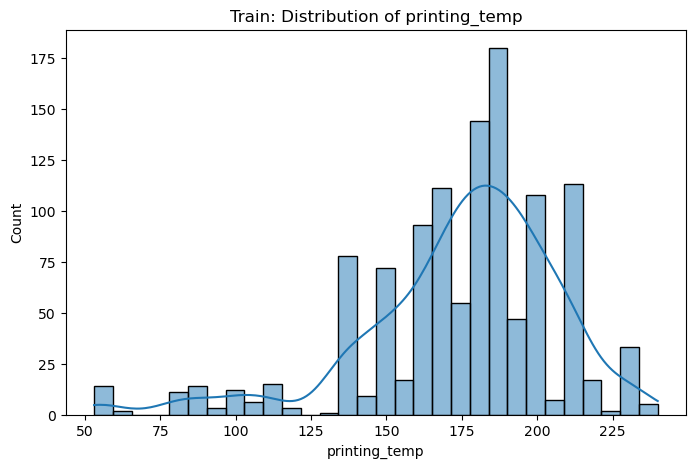

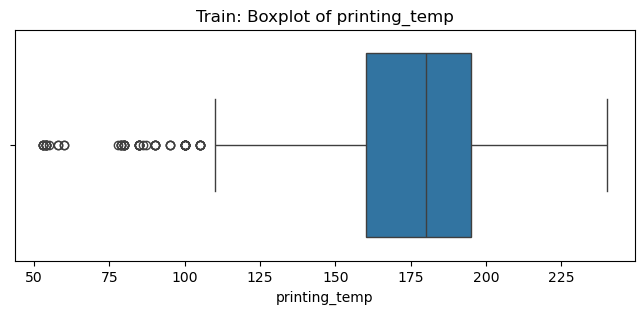

=== Target Descriptive Statistics ===
count    1172.000000
mean      174.903584
std        32.783990
min        53.000000
25%       160.000000
50%       180.000000
75%       195.000000
max       240.000000
Name: printing_temp, dtype: float64 

Skewness: -1.193
Kurtosis: 2.133


In [2]:
# 1. 划分 X, y
X = df.drop(columns=[target_col])
y = df[target_col]


# 2. 标签分布可视化 & 统计
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title(f"Train: Distribution of {target_col}")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=y)
plt.title(f"Train: Boxplot of {target_col}")
plt.show()

print("=== Target Descriptive Statistics ===")
print(y.describe(), "\n")
print(f"Skewness: {skew(y):.3f}")
print(f"Kurtosis: {kurtosis(y):.3f}")



100%|████████████████████████████████████████████████████████████████████████████████| 327/327 [00:07<00:00, 44.21it/s]

已成功填补以下特征缺失: ['extrusion_temp', 'extrusion_speed', 'printing_speed', 'platform_temp', 'nozzle_diameter']
[0]	train-rmse:31.65804	eval-rmse:30.22740


[1]	train-rmse:29.75632	eval-rmse:28.57276
[2]	train-rmse:27.83163	eval-rmse:26.84141
[3]	train-rmse:26.08159	eval-rmse:25.19524
[4]	train-rmse:24.51547	eval-rmse:23.76175
[5]	train-rmse:23.28675	eval-rmse:22.75160
[6]	train-rmse:22.04890	eval-rmse:21.70957
[7]	train-rmse:20.94946	eval-rmse:20.67532
[8]	train-rmse:20.38698	eval-rmse:20.25379
[9]	train-rmse:19.86559	eval-rmse:19.67043
[10]	train-rmse:19.29704	eval-rmse:19.17334
[11]	train-rmse:18.44788	eval-rmse:18.58257
[12]	train-rmse:17.72076	eval-rmse:18.13709
[13]	train-rmse:16.97477	eval-rmse:17.62046
[14]	train-rmse:16.33173	eval-rmse:17.12272
[15]	train-rmse:15.66534	eval-rmse:16.56713
[16]	train-rmse:15.30357	eval-rmse:16.31745
[17]	train-rmse:14.74509	eval-rmse:15.92194
[18]	train-rmse:14.46391	eval-rmse:15.63839
[19]	train-rmse:13.96675	eval-rmse:15.24067
[20]	train-rmse:13.59869	eval-rmse:15.01533
[21]	train-rmse:13.18758	eval-rmse:14.76881
[22]	train-rmse:12.77803	eval-rmse:14.52401
[23]	train-rmse:12.47619	eval-rmse:14.337

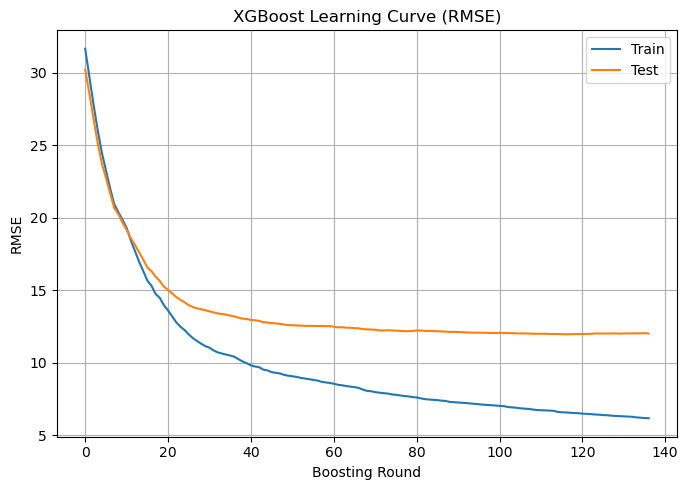

R² = 0.8561, RMSE = 12.0115, MAE = 7.8542


In [3]:

# === Step 2: 数据集划分（在任何编码、标准化之前）===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: 添加缺失标志列（数值列）===
def add_missing_flags(X_raw):
    num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
    missing_flags = pd.DataFrame(index=X_raw.index)
    for col in num_cols:
        if X_raw[col].isna().sum() > 0:
            missing_flags[f'{col}_was_missing'] = X_raw[col].isna().astype(int)
    return pd.concat([X_raw, missing_flags], axis=1)

X_train_flagged = add_missing_flags(X_train_raw)
X_test_flagged = add_missing_flags(X_test_raw)

# === Step 4: 类别填补 + One-Hot 编码 ===
cat_cols = X_train_flagged.select_dtypes(include=['object', 'category']).columns
X_train_flagged[cat_cols] = X_train_flagged[cat_cols].fillna("missing")
X_test_flagged[cat_cols] = X_test_flagged[cat_cols].fillna("missing")

X_train_encoded = pd.get_dummies(X_train_flagged, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_flagged, drop_first=True)

# 对齐测试集列（避免缺列）
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
cols = X_train_encoded.columns  # 记录列名用于 SHAP
# === Step 5: 标准化 ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

# === Step 6: 自监督 MLP 填补缺失值 ===
X_train_filled = X_train_scaled.copy()
X_test_filled = X_test_scaled.copy()
X_train_original = X_train_raw.copy()

num_cols = X_train_raw.select_dtypes(include=['float64', 'int64']).columns
filled_features = []

for col in tqdm(num_cols):
    if X_train_original[col].isna().sum() == 0:
        continue

    mask_train = X_train_original[col].isna()
    not_missing_mask = ~mask_train

    valid_cols = [c for c in X_train_scaled.columns if c != col and not X_train_scaled[c].isna().any()]
    if not valid_cols:
        continue

    X_train_feat = X_train_scaled.loc[not_missing_mask, valid_cols]
    y_train_feat = X_train_scaled.loc[not_missing_mask, col]

    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_feat, y_train_feat)

    # 填补训练集
    X_missing_feat_train = X_train_scaled.loc[mask_train, valid_cols]
    X_train_filled.loc[mask_train, col] = model.predict(X_missing_feat_train)

    # 填补测试集（注意：使用 train 模型）
    mask_test = X_test_raw[col].isna() if col in X_test_raw.columns else None
    if mask_test is not None and mask_test.any():
        X_missing_feat_test = X_test_scaled.loc[mask_test, valid_cols]
        X_test_filled.loc[mask_test, col] = model.predict(X_missing_feat_test)

    filled_features.append(col)

print(f"已成功填补以下特征缺失: {filled_features}")

# === Step 7: 使用 XGBoost 回归建模 ===
dtrain = xgb.DMatrix(X_train_filled, label=y_train)
dtest = xgb.DMatrix(X_test_filled, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]
# 定义一个空字典来接收评估结果
results_dict = {}

# 训练 XGBoost 模型并保存每一轮的评估结果
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=results_dict,
    verbose_eval=True
)

# 可视化 learning curve
results = results_dict


plt.figure(figsize=(7,5))
plt.plot(results['train']['rmse'], label='Train')
plt.plot(results['eval']['rmse'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred = model.predict(dtest)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


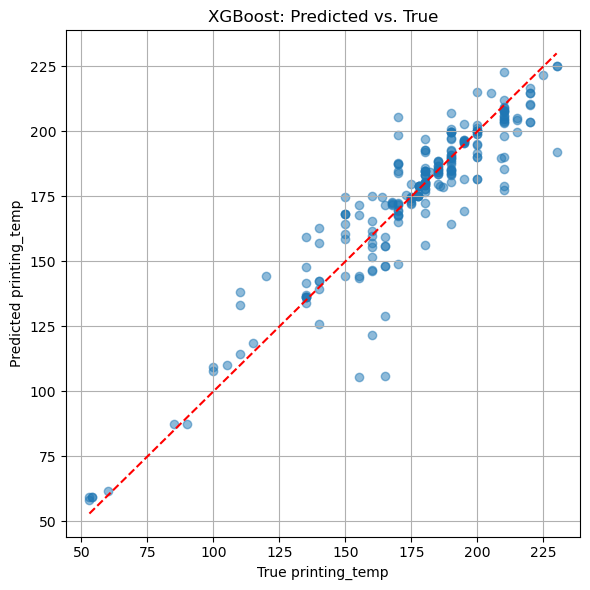

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True printing_temp")
plt.ylabel("Predicted printing_temp")
plt.title("XGBoost: Predicted vs. True")
plt.grid(True)
plt.tight_layout()
plt.show()


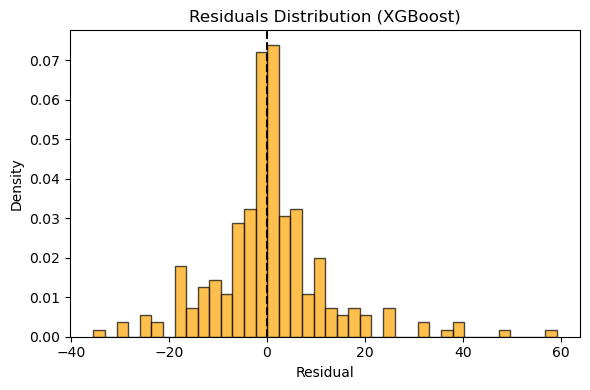

In [5]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black', alpha=0.7, density=True)
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


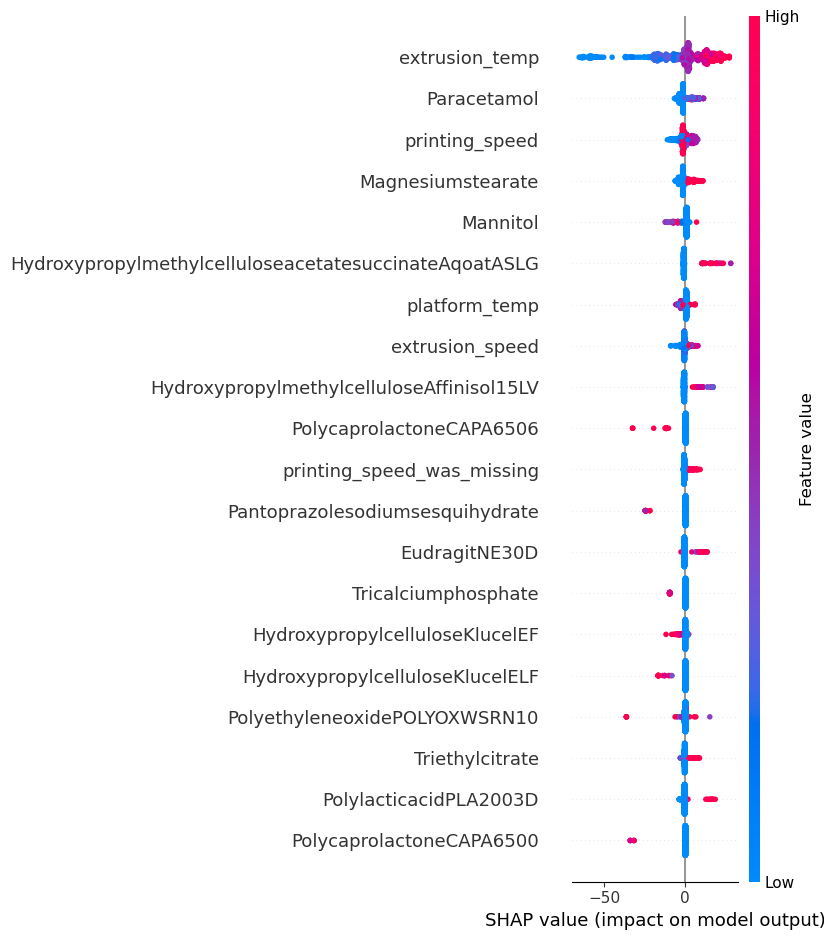

In [6]:
import shap
# 11. SHAP 可视化
shap.initjs()
explainer = shap.TreeExplainer(model)
# 转为 numpy array 形式（和训练模型一致）
shap_values = explainer.shap_values(X_train_filled.values)


shap.summary_plot(shap_values, X_train_filled, feature_names=cols)


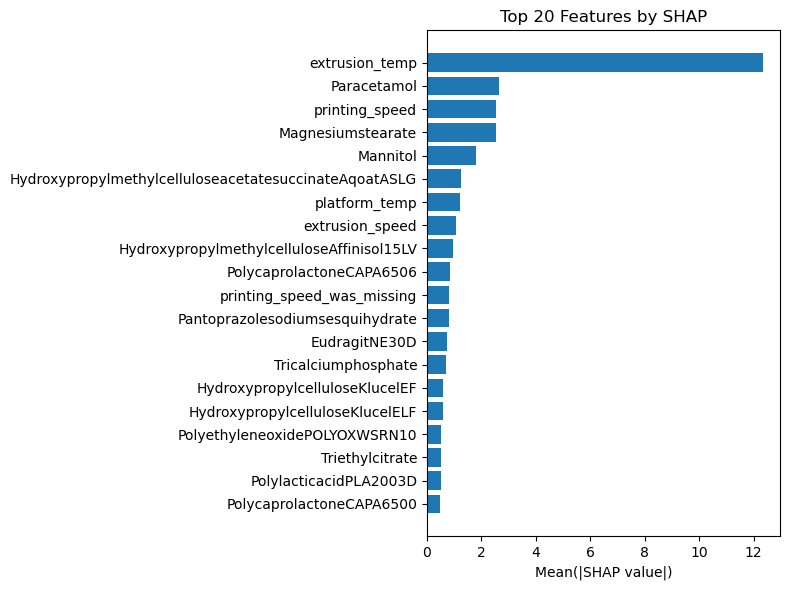

In [7]:
mean_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    'feature': X_train_filled.columns,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# 获取 Top70 特征名
shap_top_70 = shap_df.head(70)
shap_top_features = shap_top_70['feature'].tolist()

# 可视化 Top20 特征（倒序显示）
plt.figure(figsize=(8, 6))
plt.barh(
    shap_top_70['feature'][:20][::-1],
    shap_top_70['mean_abs_shap'][:20][::-1]
)
plt.title("Top 20 Features by SHAP")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()


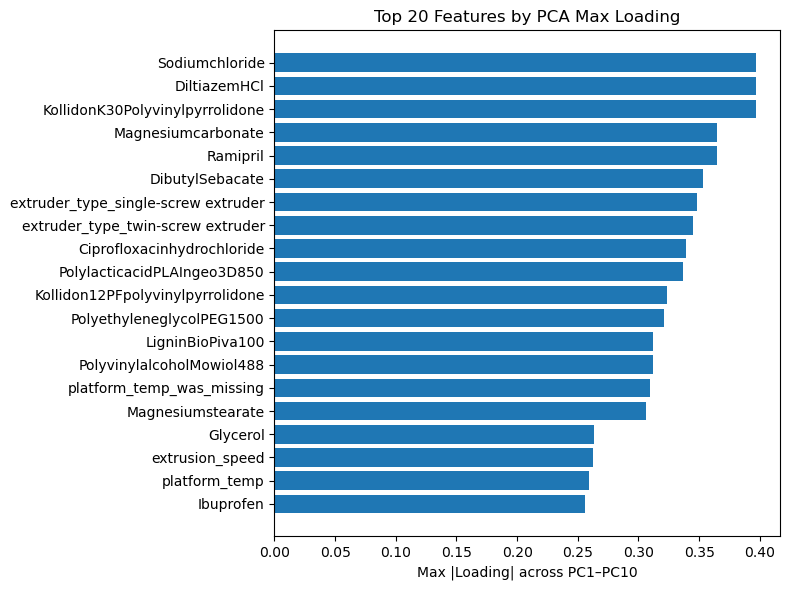

In [8]:
from sklearn.decomposition import PCA

# 设置保留主成分个数
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_filled)

# 获取每个主成分对应的所有特征 loading
loadings = np.abs(pca.components_) 

# 计算每个特征在所有主成分中的“最大 loading”
max_loading_per_feature = loadings.max(axis=0)

# 映射回特征名
pca_df = pd.DataFrame({
    'feature': cols,
    'max_loading': max_loading_per_feature
}).sort_values(by='max_loading', ascending=False)

# 取 Top 70 特征
pca_top_70 = pca_df.head(70)
pca_top_features = pca_top_70['feature'].tolist()

# 可视化 Top 20 特征的 loading 值
plt.figure(figsize=(8, 6))
plt.barh(pca_top_70['feature'][:20][::-1], pca_top_70['max_loading'][:20][::-1])
plt.title("Top 20 Features by PCA Max Loading")
plt.xlabel("Max |Loading| across PC1–PC10")
plt.tight_layout()
plt.show()


Epoch 0 - Loss: 33604.0391, Attention: μ=0.0029, σ=0.0013
Epoch 10 - Loss: 24744.1406, Attention: μ=0.0029, σ=0.0527
Epoch 20 - Loss: 31027.0488, Attention: μ=0.0029, σ=0.0527
Epoch 30 - Loss: 28103.8164, Attention: μ=0.0029, σ=0.0528
Epoch 40 - Loss: 32225.8125, Attention: μ=0.0029, σ=0.0528


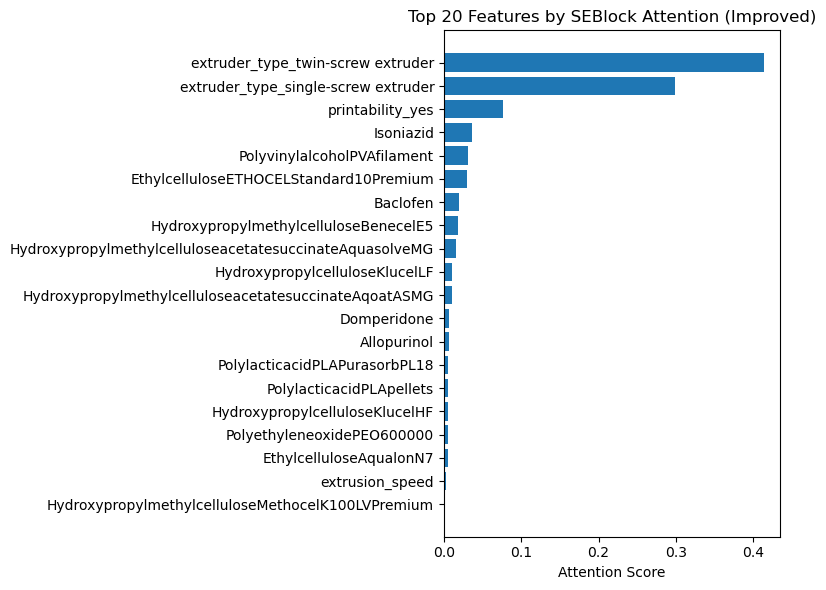

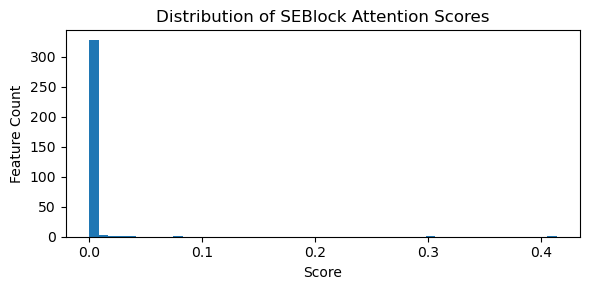

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# 1. 转换为 PyTorch 格式
X_tensor = torch.tensor(X_train_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 改进版 SEBlock 模型：用 Softmax 做特征级注意力归一化
class SEBlockMLP(nn.Module):
    def __init__(self, input_dim):
        super(SEBlockMLP, self).__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)  # 改成 Softmax，特征间相对权重
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.se(x)           # 注意力得分
        x_weighted = x * weights       # 加权特征输入
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = SEBlockMLP(X_train_filled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            _, weights = model(X_tensor)
            mean_score = weights.mean().item()
            std_score = weights.std().item()
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Attention: μ={mean_score:.4f}, σ={std_score:.4f}")

# 5. 提取注意力特征得分（取均值）
with torch.no_grad():
    _, final_weights = model(X_tensor)
    feature_scores = final_weights.mean(dim=0).numpy()

# 6. 构造 DataFrame
se_df = pd.DataFrame({
    'feature': cols,
    'attention_score': feature_scores
}).sort_values(by='attention_score', ascending=False)

# 7. 取 Top 70 特征
se_top_70 = se_df.head(70)
se_top_features = se_top_70['feature'].tolist()

# 排序 & 取前 20
se_top_20 = se_df.sort_values(by='attention_score', ascending=False).head(20)

# 可视化
plt.figure(figsize=(8, 6))
plt.barh(se_top_20['feature'][::-1], se_top_20['attention_score'][::-1])
plt.title("Top 20 Features by SEBlock Attention (Improved)")
plt.xlabel("Attention Score")
plt.tight_layout()
plt.show()

# 9. 可视化全部注意力分数分布（辅助判断是否有效区分）
plt.figure(figsize=(6, 3))
plt.hist(feature_scores, bins=50)
plt.title("Distribution of SEBlock Attention Scores")
plt.xlabel("Score")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

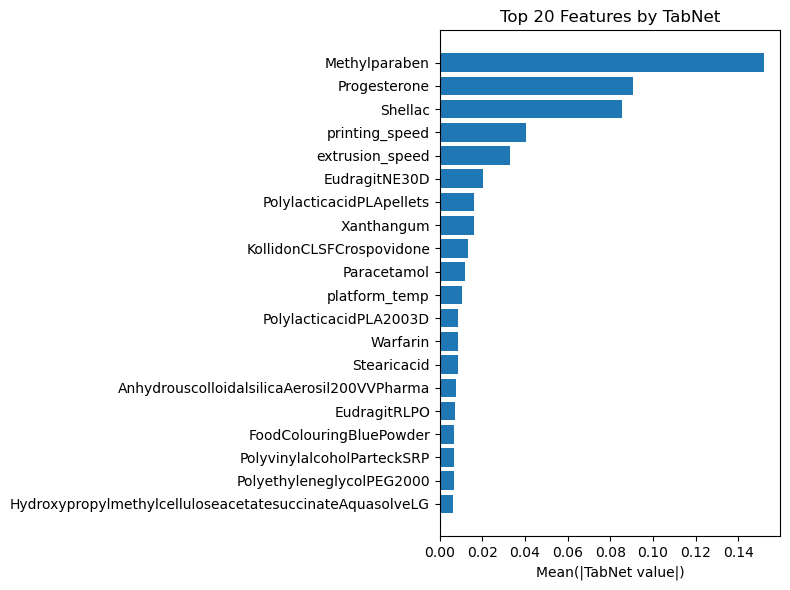

In [10]:
from pytorch_tabnet.tab_model import TabNetRegressor  

model = TabNetRegressor(seed=42)  
model.fit(
    X_train_filled.values, y_train.values.reshape(-1, 1),
    max_epochs=200,
    eval_metric='rmse'
)


importances = model.feature_importances_  # shape = (num_features,)

tabnet_feat_df = pd.DataFrame({
    'feature': cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

tabnet_top_70 = tabnet_feat_df.head(70)
tabnet_top_features = tabnet_top_70['feature'].tolist()

# 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(tabnet_top_70['feature'][:20][::-1], tabnet_top_70['importance'][:20][::-1])
plt.title("Top 20 Features by TabNet")
plt.xlabel("Mean(|TabNet value|)")
plt.tight_layout()
plt.show()


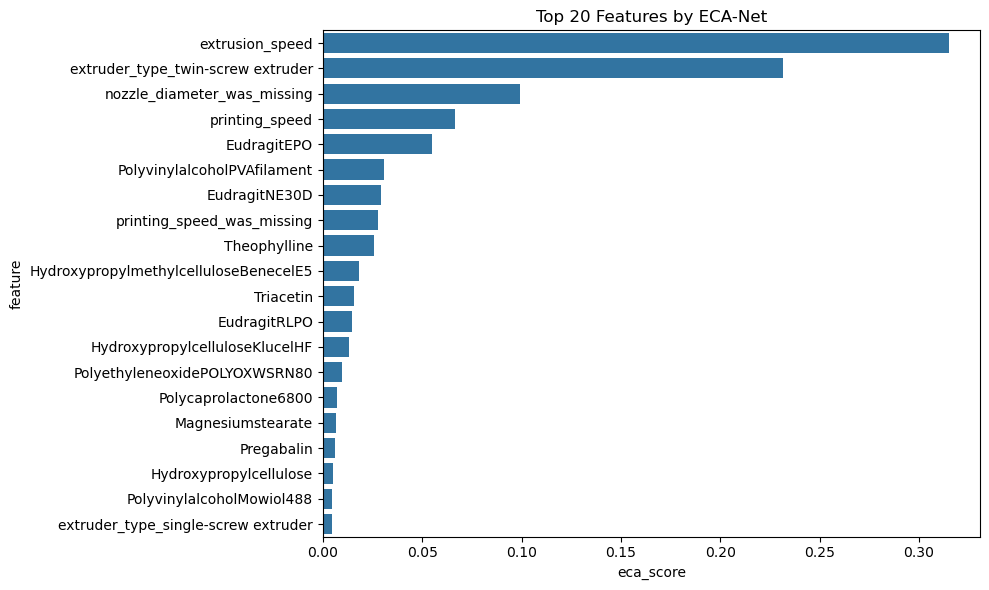

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 转换为 PyTorch 张量
X_tensor = torch.tensor(X_train_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 定义 ECA-Net 结构
class ECABlockMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.se(x)
        x_weighted = x * weights
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = ECABlockMLP(X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 5. 提取特征权重
with torch.no_grad():
    _, weights = model(X_tensor)
    attention_score = weights.mean(dim=0).numpy()

# 6. 保存成 DataFrame
eca_df = pd.DataFrame({
    'feature': cols,
    'eca_score': attention_score
}).sort_values(by='eca_score', ascending=False)

# 7. 取 Top 70 特征名列表
eca_top_70 = eca_df.head(70)
eca_top_features = eca_top_70['feature'].tolist()

# 8. 可视化 Top 20
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', x='eca_score', data=eca_top_70.head(20))
plt.title("Top 20 Features by ECA-Net")
plt.tight_layout()
plt.show()


出现在 ≥2 个方法中的特征数：93
[0]	train-rmse:30.77874	test-rmse:29.67733
[1]	train-rmse:28.74757	test-rmse:27.80575
[2]	train-rmse:26.92233	test-rmse:26.40516
[3]	train-rmse:25.32452	test-rmse:24.96666
[4]	train-rmse:24.02612	test-rmse:23.77144
[5]	train-rmse:22.92128	test-rmse:22.72933
[6]	train-rmse:21.74156	test-rmse:21.55625
[7]	train-rmse:20.76263	test-rmse:20.63794
[8]	train-rmse:19.88316	test-rmse:19.92272
[9]	train-rmse:18.98562	test-rmse:19.14096
[10]	train-rmse:18.19359	test-rmse:18.55099
[11]	train-rmse:17.63374	test-rmse:18.14145
[12]	train-rmse:17.10812	test-rmse:17.67390
[13]	train-rmse:16.66348	test-rmse:17.31456
[14]	train-rmse:16.13320	test-rmse:16.78378
[15]	train-rmse:15.62130	test-rmse:16.30067
[16]	train-rmse:15.21402	test-rmse:15.98672
[17]	train-rmse:14.75714	test-rmse:15.71056
[18]	train-rmse:14.29885	test-rmse:15.49251
[19]	train-rmse:14.01479	test-rmse:15.30378
[20]	train-rmse:13.68625	test-rmse:15.10533
[21]	train-rmse:13.36872	test-rmse:14.88996
[22]	train-rmse:13.0102

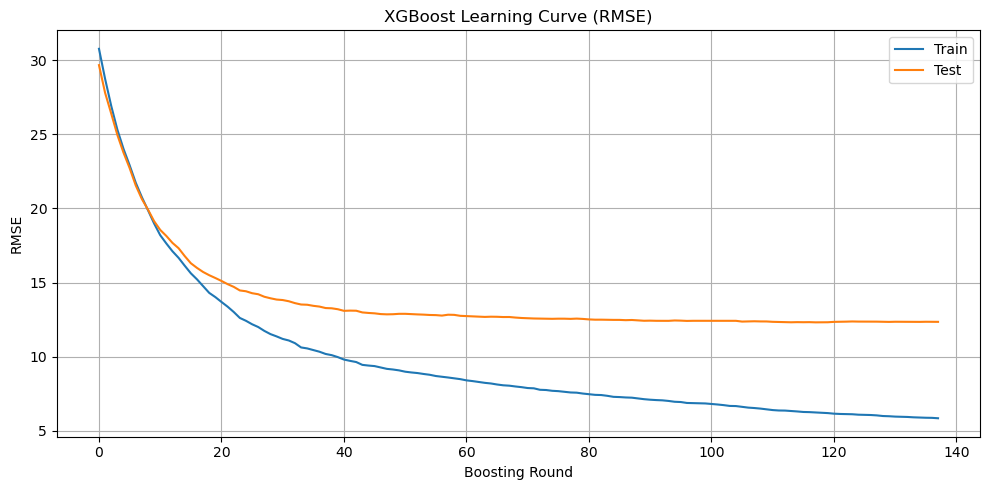

In [12]:
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# 构造“出现次数≥2”的特征子集
all_top_features = shap_top_features + pca_top_features + se_top_features + tabnet_top_features + eca_top_features
feature_counter = Counter(all_top_features)

# 筛选出现 ≥2 次的特征
selected_features = [feat for feat, count in feature_counter.items() if count >= 2]
print(f"出现在 ≥2 个方法中的特征数：{len(selected_features)}")


# 1. 特征选择 + 标准化
X_selected = X_train_filled[selected_features]
X_selected_scaled = scaler.fit_transform(X_selected)

X_test_selected = X_test_filled[selected_features]
X_test_scaled = scaler.transform(X_test_selected)

# 2. 转换为 DMatrix
dtrain = xgb.DMatrix(X_selected_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# 3. 参数设置
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 4. 训练模型
# 先创建 eval_result 字典来接收评估信息
eval_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dtest, "test")], 
    evals_result=eval_result, 
    verbose_eval=True
)

# 5. 预测 + 评估
y_pred = model.predict(dtest)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test R²: {r2:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")



# 8. 可视化学习曲线
epochs = len(eval_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, eval_result['train']['rmse'], label='Train')
plt.plot(x_axis, eval_result['test']['rmse'], label='Test')
plt.title('XGBoost Learning Curve (RMSE)')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



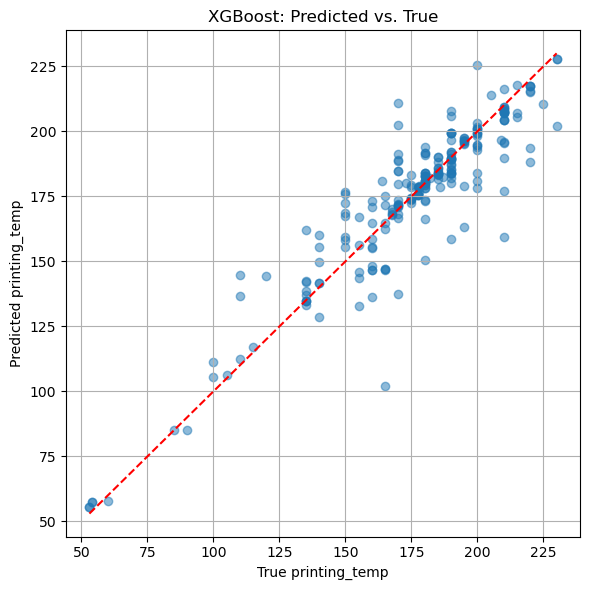

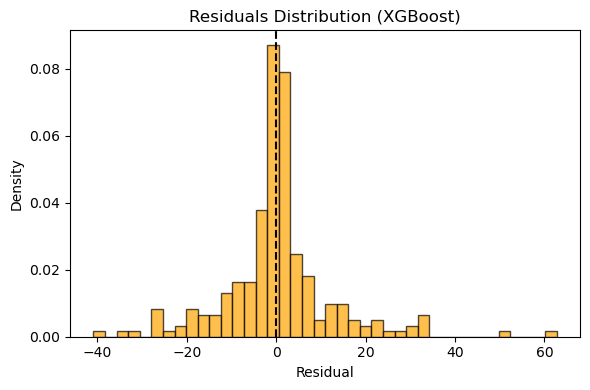

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True printing_temp")
plt.ylabel("Predicted printing_temp")
plt.title("XGBoost: Predicted vs. True")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black', alpha=0.7, density=True)
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

              Model        R2       RMSE        MAE
3          CatBoost  0.831056  13.382561   8.368870
0      XGB_Train 原生  0.828482  13.467807   8.042959
1      RandomForest  0.825175  13.610376   7.476580
2  LinearRegression  0.621840  19.910117  13.445780
4               MLP  0.340790  24.024943  11.661720
5               SVR  0.176680  29.768189  20.664800


C:\Users\PC\AppData\Local\Temp\ipykernel_7860\793019924.py:95: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_7860\793019924.py:95: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


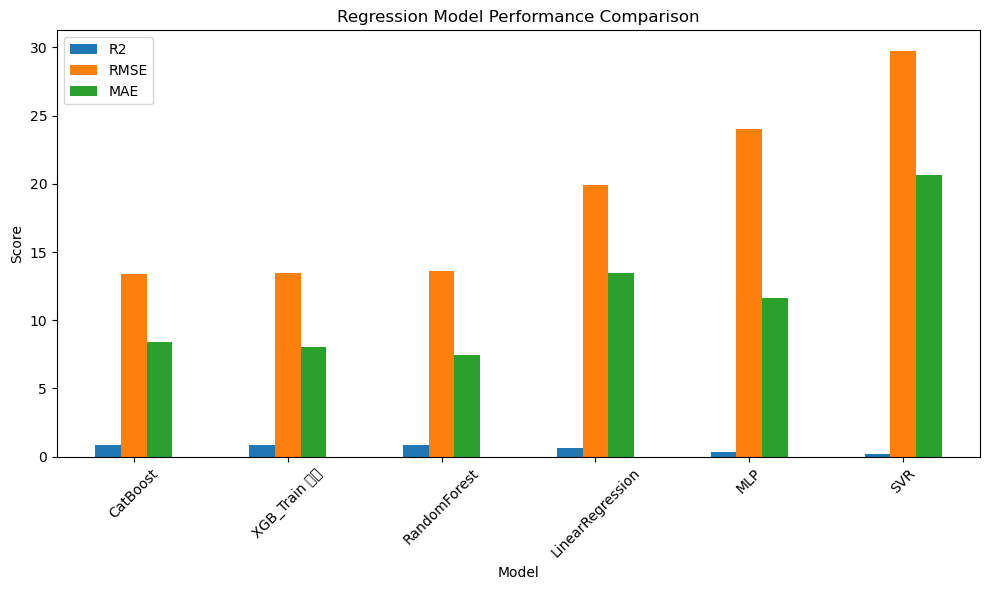

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb

class XGBTrainWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, params=None, num_boost_round=300, early_stopping_rounds=20, verbose_eval=False):
        self.params = params or {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.verbose_eval = verbose_eval
        self.model = None

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(
            self.params,
            dtrain,
            num_boost_round=self.num_boost_round,
            verbose_eval=self.verbose_eval
        )
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.model.predict(dtest)

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 自定义评分器
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  

# 交叉验证
cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

models = {
    'XGB_Train 原生': XGBTrainWrapper(),  
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42),
    'SVR': SVR(kernel='rbf')  # or 'linear', 'poly'
}


# 结果收集
results = []

for name, model in models.items():
    r2 = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring='r2').mean()
    neg_rmse = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring=rmse_scorer).mean()
    mae = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()

    results.append({
        'Model': name,
        'R2': r2,
        'RMSE': -neg_rmse,
        'MAE': -mae
    })

# 结果表格
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='R2', ascending=False)
print(df_results)

# 可视化
df_results.set_index('Model')[['R2', 'RMSE', 'MAE']].plot(kind='bar', figsize=(10,6))
plt.title("Regression Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


              Model        R2       RMSE        MAE
1      RandomForest  0.834603  13.254473   7.334081
0      XGB_Train 原生  0.830341  13.386226   8.234683
3          CatBoost  0.825713  13.545172   8.716356
2  LinearRegression  0.225333  27.641087  13.301711
5               SVR  0.088676  31.306751  21.973358
4               MLP -0.618728  38.851437  19.480551


C:\Users\PC\AppData\Local\Temp\ipykernel_7860\2632507895.py:36: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_7860\2632507895.py:36: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


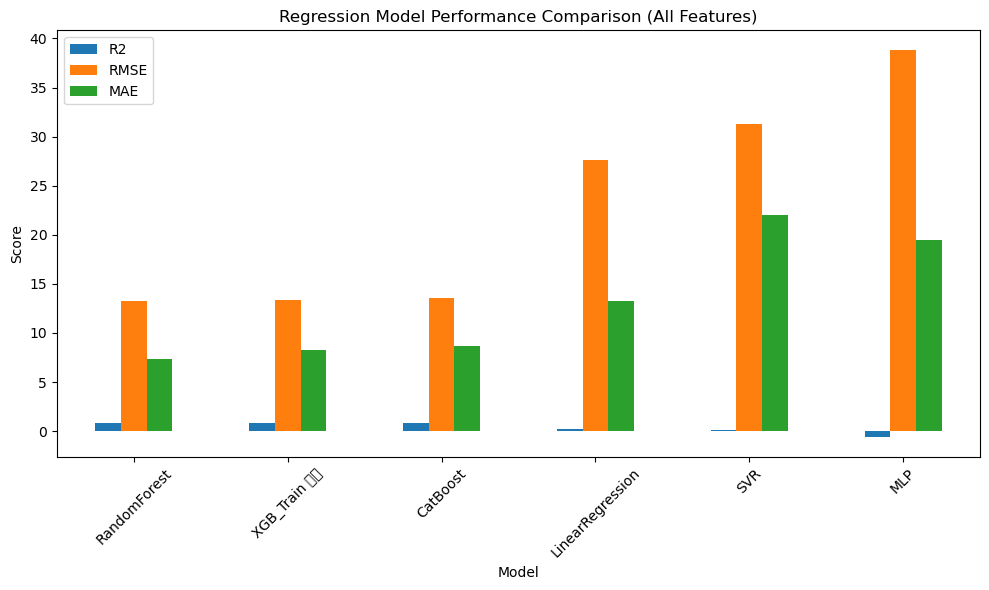

In [18]:
# 模型字典
models = {
    'XGB_Train 原生': XGBTrainWrapper(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42),
    'SVR': SVR(kernel='rbf')  # 也可尝试 'linear', 'poly'
}

# 结果收集
results = []

for name, model in models.items():
    r2 = cross_val_score(model, X_train_filled, y_train, cv=cv, scoring='r2').mean()
    neg_rmse = cross_val_score(model, X_train_filled, y_train, cv=cv, scoring=rmse_scorer).mean()
    mae = cross_val_score(model, X_train_filled, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()

    results.append({
        'Model': name,
        'R2': r2,
        'RMSE': -neg_rmse,
        'MAE': -mae
    })

# 结果表格
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='R2', ascending=False)
print(df_results)

# 可视化
df_results.set_index('Model')[['R2', 'RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6))
plt.title("Regression Model Performance Comparison (All Features)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [21]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

xgb_param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [42]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='r2',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_selected_scaled, y_train)

print("✅ Best XGBRegressor Params:", xgb_search.best_params_)
print("✅ Best XGBRegressor R2:", xgb_search.best_score_)

import joblib
joblib.dump(xgb_search.best_estimator_, "best_model_xgb_sklearn.pkl")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best XGBRegressor Params: {'subsample': 1.0, 'random_state': 42, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
✅ Best XGBRegressor R2: 0.8329333874929423


['best_model_xgb_sklearn.pkl']

In [22]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=rf_params,
    n_iter=20,
    scoring='r2',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_selected_scaled, y_train)

print("✅ Best RF Params:", rf_search.best_params_)
print("✅ Best RF R2:", rf_search.best_score_)

joblib.dump(rf_search.best_estimator_, "best_model_rf.pkl")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best RF Params: {'random_state': 42, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
✅ Best RF R2: 0.8152910971874812


['best_model_rf.pkl']

In [23]:
cat_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_state': [42]
}

cat_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0),
    param_distributions=cat_params,
    n_iter=20,
    scoring='r2',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

cat_search.fit(X_selected_scaled, y_train)

print("✅ Best CatBoost Params:", cat_search.best_params_)
print("✅ Best CatBoost R2:", cat_search.best_score_)

joblib.dump(cat_search.best_estimator_, "best_model_catboost.pkl")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best CatBoost Params: {'random_state': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 10}
✅ Best CatBoost R2: 0.8437495082602414


['best_model_catboost.pkl']

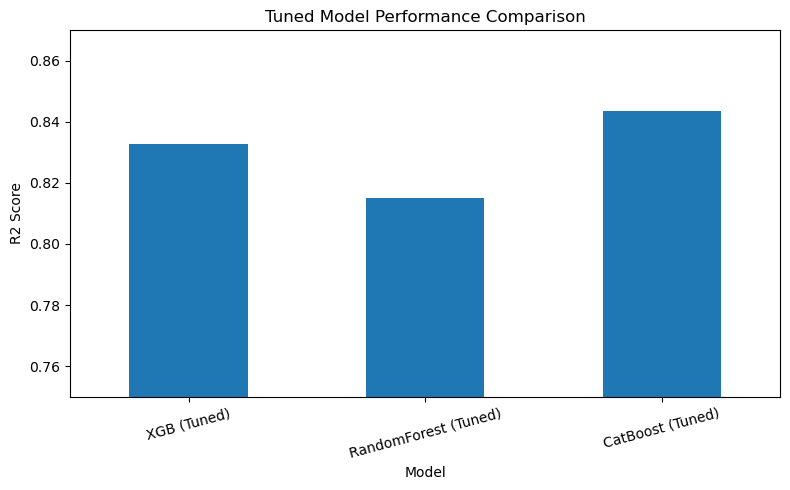

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df_best = pd.DataFrame({
    'Model': ['XGB (Tuned)', 'RandomForest (Tuned)', 'CatBoost (Tuned)'],
    'R2': [0.8329, 0.8152, 0.8437]
})

df_best.set_index('Model').plot(kind='bar', legend=False, figsize=(8,5))
plt.ylabel("R2 Score")
plt.title("Tuned Model Performance Comparison")
plt.ylim(0.75, 0.87)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


          Model        R2       RMSE       MAE
0      CatBoost  0.876549  11.123849  6.636625
2  RandomForest  0.849445  12.284473  7.328676
1  XGBRegressor  0.832331  12.963878  7.186318


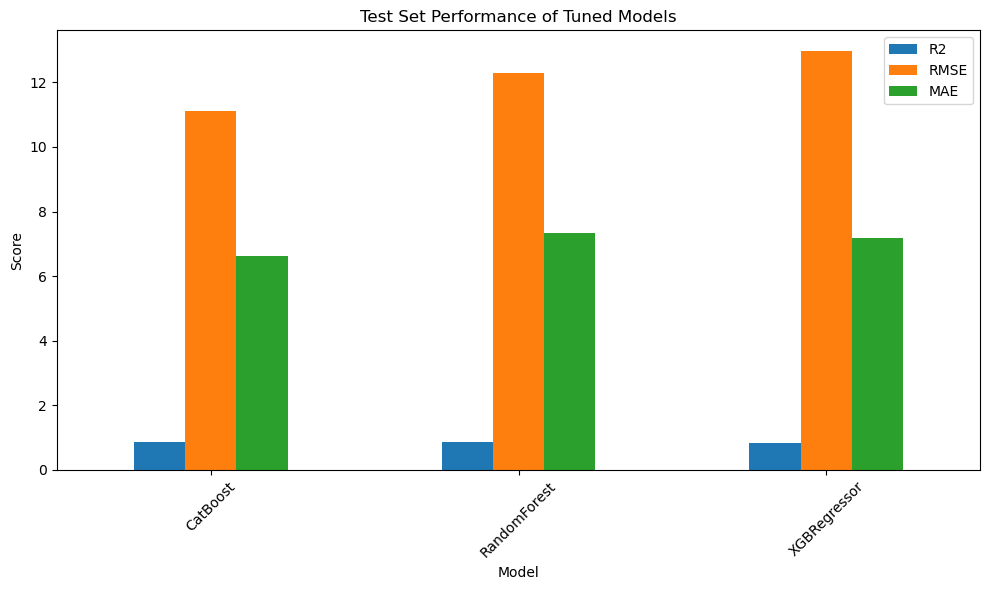

In [26]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 模型名称及对应文件路径（请根据实际文件名修改）
model_paths = {
    'CatBoost': 'best_model_catboost.pkl',
    'XGBRegressor': 'best_model_xgb_sklearn.pkl',
    'RandomForest': 'best_model_rf.pkl',
    # 可继续添加其他模型：'MLP': 'best_model_mlp.pkl'
}

# 存储结果
results = []

# 批量评估
for model_name, file_path in model_paths.items():
    model = joblib.load(file_path)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': model_name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    })

# 转为 DataFrame 并打印
df_results = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print(df_results)

df_results.set_index('Model')[['R2', 'RMSE', 'MAE']].plot(kind='bar', figsize=(10,6))
plt.title("Test Set Performance of Tuned Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_7860\3161256082.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, show=True)


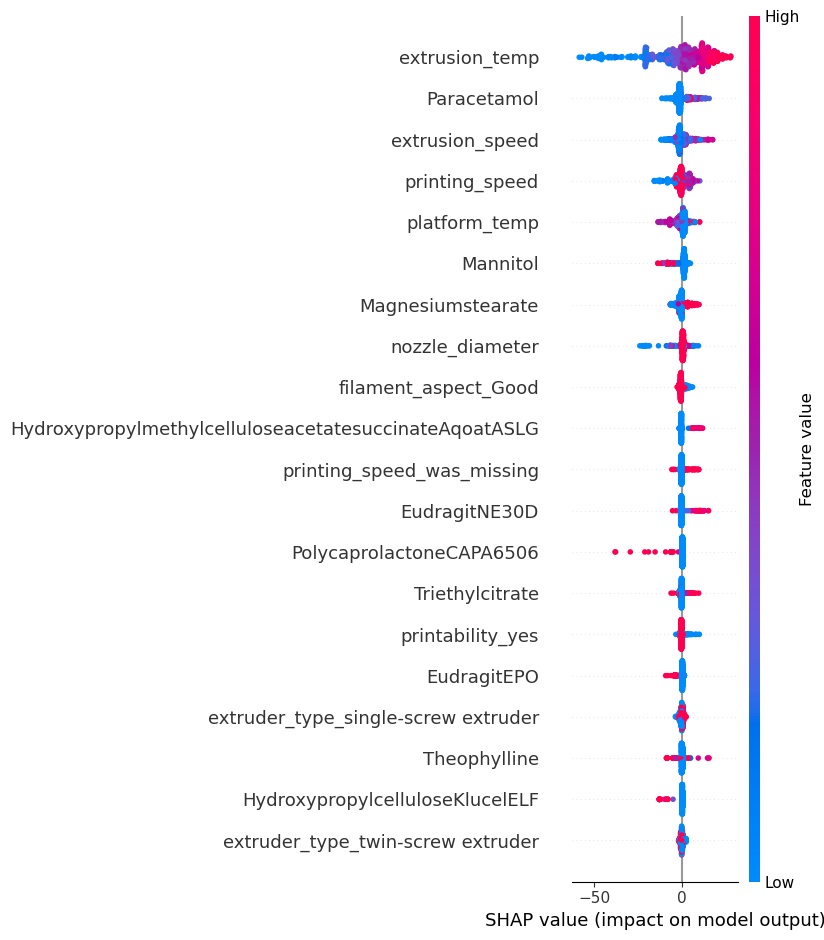

In [31]:
import shap
import joblib
import pandas as pd

# === 加载模型 ===
model = joblib.load("best_model_catboost.pkl")

# === 构造带列名的 DataFrame ===
X_shap = pd.DataFrame(X_selected_scaled, columns=selected_features, index=X_selected.index)

# === TreeExplainer 可用 ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# === summary plot 可视化 ===
shap.summary_plot(shap_values, X_shap, show=True)





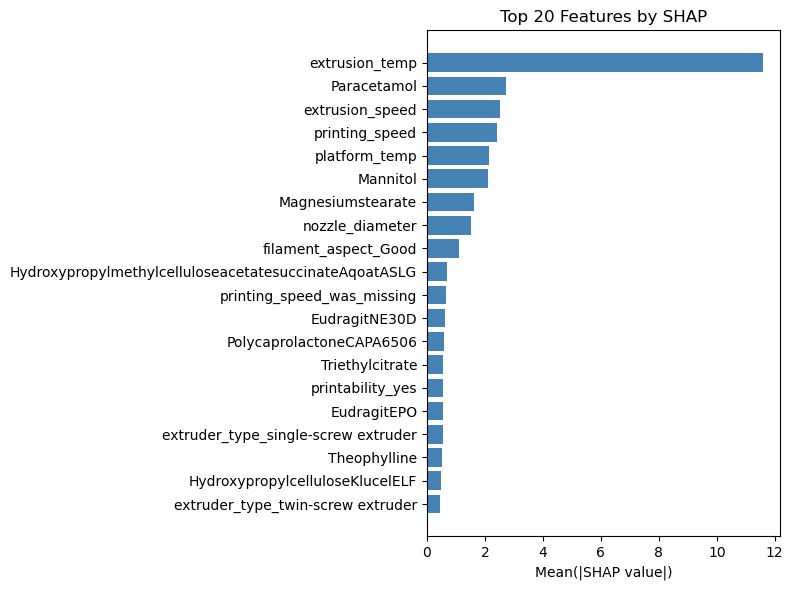

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 计算 mean(|SHAP|) 值 ===
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_shap_importance = pd.DataFrame({
    'Feature': X_shap.columns,
    'Mean(|SHAP value|)': mean_abs_shap
}).sort_values(by='Mean(|SHAP value|)', ascending=False)

# === 只取 Top 20 ===
df_top20 = df_shap_importance.head(20).sort_values(by='Mean(|SHAP value|)', ascending=True)

# === 绘图 ===
plt.figure(figsize=(8, 6))
plt.barh(df_top20['Feature'], df_top20['Mean(|SHAP value|)'], color='steelblue')
plt.xlabel('Mean(|SHAP value|)')
plt.title('Top 20 Features by SHAP')
plt.tight_layout()
plt.show()

